In [ ]:
#Imports

import os, warnings

# !pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

# !pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import scipy.io
import numpy as np
print(tf.__version__)

# Horovod for distributed training 
import horovod.tensorflow.keras as hvd

# Sagemaker for running on AWS
import sagemaker
from sagemaker.utils import sagemaker_timestamp
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

default_s3_bucket = sagemaker_session.default_bucket()
sagemaker_iam_role = get_execution_role()


In [24]:
# Intialize Horovod 

hvd.init()

In [25]:
# Pick the master GPU
# Pin GPU to be used to process local rank (one GPU per process)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')


In [26]:
# Check available GPU's for Horovod

print(hvd.local_size())

In [27]:
#Import and process annotations

cars_meta = scipy.io.loadmat('./Annos/cars_meta.mat')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)

train_annos = scipy.io.loadmat('./Annos/cars_train_annos.mat')
train_annos = train_annos['annotations']
train_annos = np.transpose(train_annos)

test_annos = scipy.io.loadmat('./Annos/cars_test_annos_withlabels.mat')
test_annos = test_annos['annotations']
test_annos = np.transpose(test_annos)

def format_annotations(data):

    annos = []
 
    for annotation in data:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        fname = annotation[0][5][0]
        annos.append([fname,[bbox_x1, bbox_y1, bbox_x2, bbox_y2],class_id])
    
    return(annos)

train_annotations = format_annotations(train_annos)
test_annotations = format_annotations(test_annos)

#get annotations train_annotations[0][2]. First index is the number of images.  Second index is [0] for frame name. [1] for box. [2] for class_id

#save labels as list
def labels_list(data):

    labels = []

    for label in data:
        labels.append(label[2])

    return(labels)

def fnames_list(data):

    fnames = []

    for fname in data:
        fnames.append(fname[0])
    
    return(fnames)

train_labels = labels_list(train_annotations)
test_labels = labels_list(test_annotations)


train_fnames = fnames_list(train_annotations)
test_fnames = fnames_list(test_annotations)

In [ ]:
# Test to see if images, bounding boxes, and labels are formatted correctly

print(train_annotations[8143])
print(train_annotations[0][1])
index = 0
x1 = train_annotations[index][1][0]
y1 = train_annotations[index][1][1]
x2 = train_annotations[index][1][2]
y2 = train_annotations[index][1][3]
print(x1,y1,x2,y2)

print(test_annotations[0])
print(test_annotations[0][1])
index = 0
x1 = test_annotations[index][1][0]
y1 = test_annotations[index][1][1]
x2 = test_annotations[index][1][2]
y2 = test_annotations[index][1][3]
print(x1,y1,x2,y2)

In [ ]:
# Directories for train and test images

directory_train = './cars196_train/'
directory_test = './cars196_test/'

#Use Crop_Images.py if running for the first time. 

# Create Datasets
ds_train = tf.data.Dataset.from_tensor_slices((train_fnames, train_labels))
ds_test = tf.data.Dataset.from_tensor_slices((test_fnames, test_labels))

def train_read_image(image_file, label):
    image = tf.io.read_file(directory_train + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def test_read_image(image_file, label):
    image = tf.io.read_file(directory_test + image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    return image, label

def augment(image_file,label):
    image_size = [256,256]
    num_channels = 3
    interpolation = 'nearest'
    img = tf.image.resize(image_file, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img, label

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

def load_images(data):

    images = []

    for image in data:
        image = tf.io.read_file(directory_train + image)
        image = tf.image.decode_jpeg(image, channels=3)
        images.append(image)

    return images

# Take the training dataset which is sized and labeled.  Convert to pixel array.   

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(train_read_image).map(augment).map(convert_to_float)
ds_test = ds_test.map(test_read_image).map(augment).map(convert_to_float)


# Combining the test and train datasets.  The original 50/50 split does not have enough images for training. 80% train, 10% validation, 10% test
ds_temp = ds_train.concatenate(ds_test)
ds_valid = ds_temp.take(1500)
ds_temp = ds_temp.skip(1500) 
ds_test = ds_temp.take(1500)
ds_train = ds_temp.skip(1500)

print(len(ds_test))
print(len(ds_valid))
print(len(ds_train))

# Cache in memory for faster runtime.  Autotune sets up the CPU so it's fetching the next image in the list while the current image is in the CNN. 
ds_train = ds_train.batch(64).cache().prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_test.batch(64).cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.batch(64).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Comment out base you are not using. 

# InceptionV3 pretrained base.

# pretrained_base = tf.keras.applications.inception_v3.InceptionV3(
#     include_top=False, weights='imagenet', input_tensor=None,
#     input_shape=[256,256,3], pooling=None, classes=1000,
#     classifier_activation='softmax'
# )
# pretrained_base.trainable = False

# VGG16 pretrained base.
pretrained_base = tf.keras.applications.vgg19.VGG19(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=[256,256,3], pooling=None,
    classifier_activation='softmax'
)

# Should you train conv2D blocks in pretrained base?

# pretrained_base.trainable = False

set_trainable = False
for layer in pretrained_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False




In [31]:
# Stop early if the accucary is not improving enough. Tested but did not end up using 

# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(
#     min_delta=0.0005, # minimium amount of change to count as an improvement
#     patience=15, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

In [32]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.5),
#     layers.experimental.preprocessing.RandomTranslation((-0.2,0.2),(-0.2,0.2)),
#     layers.experimental.preprocessing.Rescaling(scale=1./255),
#     layers.experimental.preprocessing.RandomZoom((0,0.2)),
    

])

In [34]:
# Multiple CNN Model's.  Comment out models not in use.

# First Simple Model

# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(units=512, activation='relu'),
#     layers.Dense(units=197, activation='softmax')
# ])



# Model with a pretrained base & data augmentation 

# model = keras.Sequential([
#     data_augmentation,
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(units=4096, activation="relu"),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(units=2048, activation="relu"),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(units=1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(units=512, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(units=256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(units=197, activation="softmax"),
# ])



# Custom base 

model = tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomContrast(0.2),

    # First Convolutional Block
    # 32 filter layers, Kernel Size of 5 x 5. Relu activation.  Add zeroes all around so the image doesn't change size, Padding='same'.
    
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[256, 256, 3]),
    
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
 
    layers.MaxPool2D(),
    

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    
    layers.MaxPool2D(),
    layers.BatchNormalization(),

    #Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    
    layers.MaxPool2D(),
    

    #Fifth Convolutional Block
    layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding='same'),
   
    layers.MaxPool2D(),
    
    #Fifth Convolutional Block
    layers.Conv2D(filters=1024, kernel_size=3, activation="relu", padding='same'),
  
    layers.MaxPool2D(),

   
#     # Classifier Head.  Fully connected Dense layer with 6 nodes and a relu activation.  Final node for binary decision. 
    layers.Flatten(),
    layers.Dense(units=2048, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(units=197, activation="softmax"),

])

In [ ]:
# If using Horovod use this optimizer
# opt = tf.optimizers.Adam(0.001 * hvd.size())
# opt = hvd.DistributedOptimizer(opt)

# Otherwise set the optimizer to Adam with a learning rate of 0.0001

opt = tf.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [35]:
# Horovod: broadcast initial variable states from rank 0 to all other processes.
# This is necessary to ensure consistent initialization of all workers when
# training is started with random weights or restored from a checkpoint.

callbacks = [
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),
]

In [36]:
# Horovod: save checkpoints only on worker 0 to prevent other workers from corrupting them.

if hvd.rank() == 0:
    callbacks.append(keras.callbacks.ModelCheckpoint('./checkpoint-{epoch}.h5'))

Train

In [ ]:

# Horovod: adjust number of epochs based on number of GPUs.
# epochs = int(math.ceil(30 / hvd.size()))

# If not using Horovod set the epochs here
epochs = 100


# Fit the Model. 
history = model.fit(
    ds_train,
    validation_data = ds_valid,
    steps_per_epoch=500 // hvd.size(),
    epochs = epochs,
#     callbacks=[early_stopping], 
    verbose=1 if hvd.rank() == 0 else 0
)

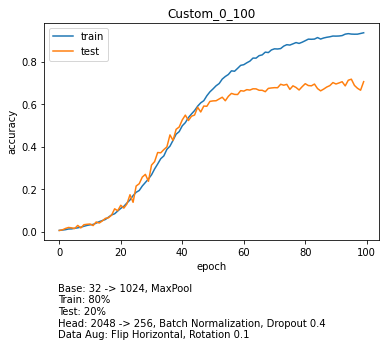

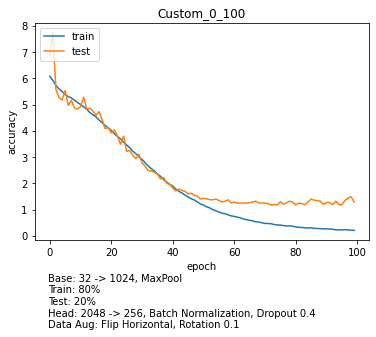

In [ ]:
# Plot the accuracy and loss after 30 Epochs

# caption = 'Base: VGG19' '\n' 'Convd 5 trainable''\n' 'Train: 80%''\n''Test: 20%''\n''Head: 4096 -> 256, Batch Normalization, Dropout: 0.25' '\n' 'Data Aug: Flip Horizontal, Rotation 0.1, Contrast: 0.2'
caption = 'Base: 32 -> 1024, MaxPool' '\n' 'Train: 80%''\n''Test: 20%''\n''Head: 2048 -> 256, Batch Normalization, Dropout 0.4' '\n' 'Data Aug: Flip Horizontal, Rotation 0.1' 

# Train/Test Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Custom_0_100')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.text(-.5,-.5, caption)

# Save as PDF
plt.savefig("Custom_0_100_2048_256_Norm_Dropout_accuracy.pdf", bbox_inches = "tight")
plt.show()

# Train/Test Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Custom_0_100')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.text(-.5,-3.5, caption)

# Save as PDF
plt.savefig("Custom_0_100_2048_256_Norm_Dropout_loss.pdf", bbox_inches = "tight")
plt.show()

# Save Model
model.save('vgg19_30_100_2048_256_Norm_Dropout.h5')

In [ ]:
# Accuracy of model on test images

metrics = model.evaluate(ds_test, verbose=0)
print("test loss, test acc:", metrics)